# Vascular age - example

## Setup

### Import libraries

In [ ]:
! pip install wfdb
! pip install neurokit2

In [2]:
import neurokit2 as nk2
import wfdb

In [3]:
import numpy as np
from scipy import signal
from statistics import median
import matplotlib.pyplot as plt

### Setup database

In [4]:
# Specify the database
database_name = 'pulse-transit-time-ppg/1.1.0' # The name of the database on Physionet

# Find a list of records in the database
record_list = wfdb.get_record_list(database_name)

# Output the result
print(f"The '{database_name}' database contains {len(record_list)} records")

The 'pulse-transit-time-ppg/1.1.0' database contains 66 records


### Import required functions

- Finding suitable records in the database

In [5]:
def find_suitable_records(required_signals, required_duration, required_activity, do_verbose=False):
    """
    Description: Finds suitable records in the Pulse Transit Time PPG dataset.
    """    
    
    matching_recs = {'dir':[], 'name':[], 'length':[], 'start_sbp':[], 'end_sbp':[], 'delta_sbp':[], 'age':[]}

    for record in record_list:
        if do_verbose:
            print('Record: {}'.format(record), end="", flush=True)
    
        # check whether this record corresponds to a suitable activity
        if not required_activity in record:
            if do_verbose:
                print('   (not required activity)')
            continue

        record_data = wfdb.rdheader(record,
                                    pn_dir=database_name,
                                    rd_segments=True)

        # Check whether the required signals are present in the record
        sigs_present = record_data.sig_name
        if not all(x in sigs_present for x in required_signals):
            if do_verbose:
                print('   (missing signals)')
            continue

        seg_length = record_data.sig_len/(record_data.fs)

        if seg_length < required_duration:
            if do_verbose:
                print(f' (too short at {seg_length/60:.1f} mins)')
            continue
    
        # This record does meet the requirements, so extract information and data from it
    
        # Information
        matching_recs['dir'].append(database_name)
        matching_recs['name'].append(record_data.record_name)
        matching_recs['length'].append(seg_length)
    
        # Blood pressure measurements
        str_to_find = '<bp_sys_start>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_end>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['start_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        str_to_find = '<bp_sys_end>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_dia_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['end_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        matching_recs['delta_sbp'].append(matching_recs['end_sbp'][-1]-matching_recs['start_sbp'][-1])

        # ages
        str_to_find = '<age>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['age'].append(float(record_data.comments[0][start_el:end_el]))

        if do_verbose:
            print('   (met requirements)')
    
    if do_verbose:
        print(f"A total of {len(matching_recs['dir'])} out of {len(record_list)} records met the requirements.")
    
    return matching_recs

- Extracting a segment of data from a record

In [6]:
def extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose=False):

    # Get sampling frequency from header data
    record_data = wfdb.rdheader(record_name,
                                pn_dir=record_dir,
                                rd_segments=True)
    fs = record_data.fs
    
    # Specify timings of segment to be extracted
    sampfrom = fs * start_seconds
    sampto = fs * (start_seconds + n_seconds_to_load)

    # Load segment data
    segment_data = wfdb.rdrecord(record_name=record_name,
                                 channel_names = required_signals,
                                 sampfrom=sampfrom,
                                 sampto=sampto,
                                 pn_dir=record_dir)

    if do_verbose:
        print(f"{n_seconds_to_load} seconds of data extracted from record: {record_name}")
    
    return segment_data

- Find peaks in PPG signal

In [7]:
def get_ppg_peaks(raw, fs):
  ppg_clean = nk2.ppg_clean(raw, sampling_rate=fs)
  peaks = nk2.ppg_findpeaks(ppg_clean, method="elgendi", show=False)  
  return peaks['PPG_Peaks']

- Find peaks in ECG signal

In [8]:
def get_ecg_peaks(raw, fs):
    ecg_clean = nk2.ecg_clean(raw, sampling_rate=fs)
    signals, info = nk2.ecg_peaks(ecg_clean, method="neurokit", show=False)  
    peaks = info["ECG_R_Peaks"]
    return peaks

- Find PPG pulse onsets

In [9]:
def get_ppg_onsets(ppg, pks, fs):
    ons = np.empty(0)
    for i in range(len(pks) - 1):
        start = pks[i]
        stop = pks[i + 1]
        ibi = ppg[start:stop]
        aux_ons = np.argmin(ibi)
        # aux_ons, = np.where(ibi == np.min(ibi))
        ind_ons = aux_ons.astype(int)
        ons = np.append(ons, ind_ons + start)   

    ons = ons.astype(int)
    return ons

- A function to find the index in a list which immediately follows a specified point

In [10]:
def find_next(array, value):
    array = np.asarray(array)
    diffs = array - value
    diffs = np.where(diffs>0, diffs, 100000)
    idx = diffs.argmin()
    return array[idx]

# Extracting a dataset

## Finding suitable records in the database

In [ ]:
# specify requirements
name_of_ecg_signal = "ecg"
name_of_ppg_signal = "pleth_1"
required_signals = [name_of_ecg_signal, name_of_ppg_signal]
required_duration = 1*60 # in seconds
required_activity = "sit"

# find records which meet these requirements
do_verbose = True
matching_recs = find_suitable_records(required_signals, required_duration, required_activity, do_verbose)

## Extract data from a record

In [ ]:
# specify details of data to be extracted
start_seconds = 0
n_seconds_to_load = 60
record_name = matching_recs['name'][0]
record_dir = matching_recs['dir'][0]

# extract these data
do_verbose = True
segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose)

# Signal processing

## Extract signals

- Extract PPG and ECG signals

In [13]:
sig_list = ["ppg", "ecg"]
for sig in sig_list:
    exec("curr_sig_name = name_of_" + sig + "_signal")
    rel_col = segment_data.sig_name.index(curr_sig_name)
    exec(sig + " = segment_data.p_signal[:,rel_col]")

- Extract sampling frequency

In [14]:
fs = segment_data.fs

## Invert PPG signal

In [15]:
ppg = -1*ppg

## Filter signals

- Filter PPG

In [16]:
ppg = nk2.ppg_clean(ppg, sampling_rate=fs)

- Filter ECG

In [17]:
ecg = nk2.ecg_clean(ecg, sampling_rate=fs)

## Beat detection

### PPG beat detection

- Detect beats

In [18]:
ppg_peaks = get_ppg_peaks(ppg, fs)

- Plot results

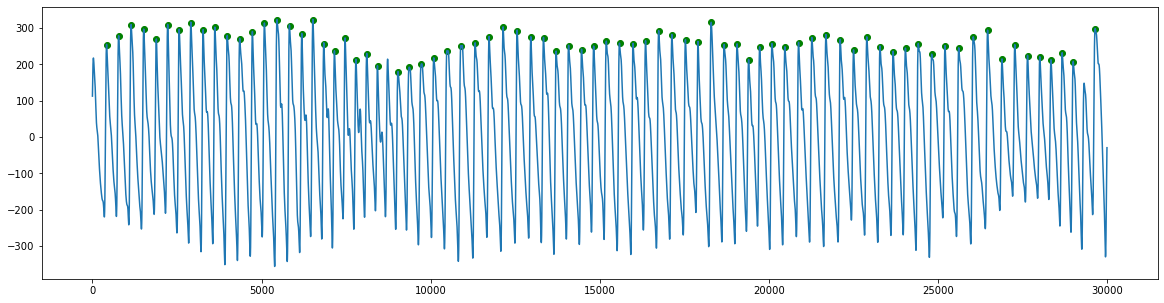

In [48]:
plt.figure(figsize=(20,5))
plt.plot(ppg)
heights = ppg[ppg_peaks]
plt.scatter(ppg_peaks, heights, marker='o', color='green')
plt.show()

### ECG beat detection

- Detect beats

In [20]:
ecg_peaks = get_ecg_peaks(ecg, fs)

- Plot results

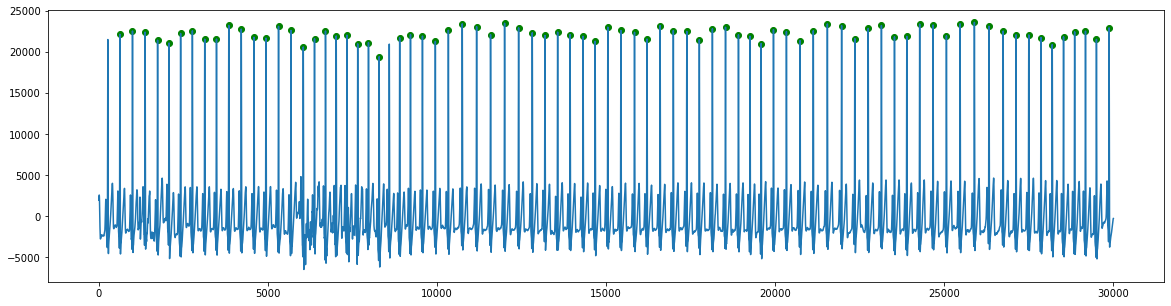

In [47]:
plt.figure(figsize=(20,5))
plt.plot(ecg)
heights = ecg[ecg_peaks]
plt.scatter(ecg_peaks, heights, marker='o', color='green')
plt.show()

## Extract timings

### ECG timings

The ECG timings are simply the times of the R-waves, which indicate the times of ventricular depolarisation (i.e. the electrical activity which prompts ventricular contraction).

In [22]:
ecg_timings = ecg_peaks

### PPG timings

Ideally, we wouldn't use the times of systolic peaks on PPG waves, because there can be a variable delay between the pulse onset and systolic peak. Therefore, we use an alternative, such as the time of pulse onset:

- Getting the times of PPG pulse wave onsets

In [23]:
ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)

- Plotting the results

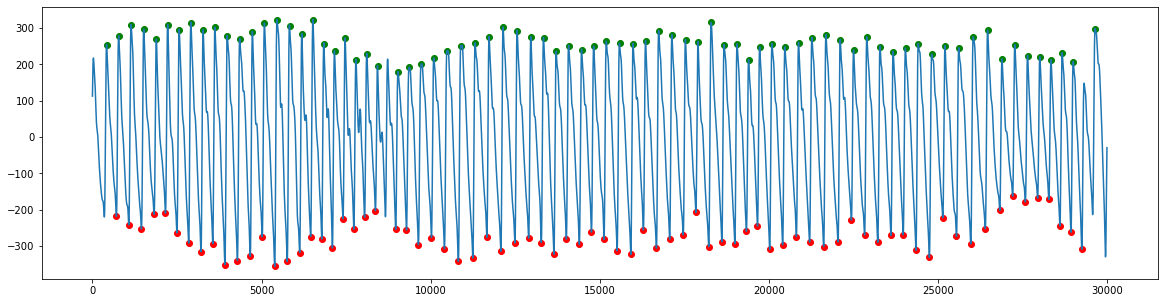

In [49]:
plt.figure(figsize=(20,5))
plt.plot(ppg)
heights_peaks = ppg[ppg_peaks]
heights_onsets = ppg[ppg_timings]
plt.scatter(ppg_peaks, heights_peaks, marker='o', color='green')
plt.scatter(ppg_timings, heights_onsets, marker='o', color='red')
plt.show()

## Extract pulse arrival times

- Find pairs of R-waves and subsequent PPG pulse onsets

In [25]:
rel_ppg_timings = []
for ecg_timing in ecg_timings:
    current_ppg_timing = find_next(ppg_timings, ecg_timing)
    rel_ppg_timings.append(current_ppg_timing)

- Calculate pulse arrival times as the difference between the times of R-waves and subsequent PPG pulse onsets

In [26]:
pats = (rel_ppg_timings - ecg_timings)/fs

# Modelling

## Extract dataset

Extract a dataset of:
- Parameter(s) derived from PPG and ECG signals: pulse arrival time
- Reference parameter(s): age

### Setup:

In [27]:
subj_nos = [i for i in range(len(matching_recs['name']))]

### Extract median pulse arrival times

In [ ]:
median_pats = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's signals
    segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals)
    fs = segment_data.fs
    sig_list = ["ppg", "ecg"]
    for sig in sig_list:
        exec("curr_sig_name = name_of_" + sig + "_signal")
        rel_col = segment_data.sig_name.index(curr_sig_name)
        exec(sig + " = segment_data.p_signal[:,rel_col]")
        
    # invert PPG signal
    ppg = -1*ppg
    
    # filter signals
    ppg = nk2.ppg_clean(ppg, sampling_rate=fs)
    ecg = nk2.ecg_clean(ecg, sampling_rate=fs)
    
    # detect beats in signals
    ecg_peaks = get_ecg_peaks(ecg, fs)
    ppg_peaks = get_ppg_peaks(ppg, fs)
    
    # obtain timings
    ecg_timings = ecg_peaks
    ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)
    
    # extract pulse arrival times
    rel_ppg_timings = []
    for ecg_timing in ecg_timings:
        current_ppg_timing = find_next(ppg_timings, ecg_timing)
        rel_ppg_timings.append(current_ppg_timing)
    pats = (rel_ppg_timings - ecg_timings)/fs
    
    # find median pulse arrival time for this subject
    curr_median_pat = median(pats)
    median_pats.append(curr_median_pat)
    
    print(f"Subject no. {subj_no} has median PAT of {median_pats[subj_no]} seconds")

### Extract ages

In [29]:
ages = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's age
    curr_age = matching_recs['age'][subj_no]
    ages.append(curr_age)

## Inspect dataset

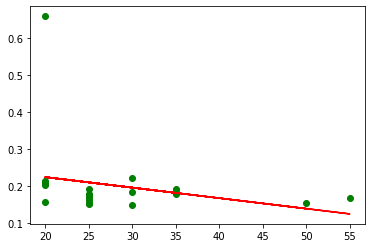

In [50]:
plt.scatter(ages, median_pats, marker='o', color='green')
m, b = np.polyfit(ages, median_pats, 1)
plt.plot(ages, m*np.array(ages)+b, color='red')
plt.show()

- if we exclude the outlier:

In [32]:
rel_ages = []
rel_median_pats = []
for el in range(len(ages)):
    if median_pats[el]<0.3:
        rel_ages.append(ages[el])
        rel_median_pats.append(median_pats[el])

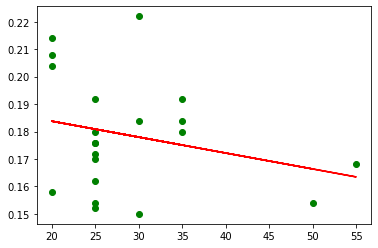

In [51]:
plt.scatter(rel_ages, rel_median_pats, marker='o', color='green')
m, b = np.polyfit(rel_ages, rel_median_pats, 1)
plt.plot(rel_ages, m*np.array(rel_ages)+b, color='red')
plt.show()

## Taking it further

- Can you assess the strength of the correlation? _Consider using the `sklearn` package [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)_